In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit

import tensorflow as tf
import tensorflow.keras.layers as tkl

sys.path.append('../')
from medl.models.random_effects2 import RandomEffects
from spirals import make_spiral_random_radius, plot_clusters, make_spiral_true_boundary

sns.set_style('whitegrid')

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
session = InteractiveSession(config=config)

tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
np.random.seed(1267)
arrX, arrZ, arrY, arrRadii = make_spiral_random_radius(10, 
                                                        inter_cluster_sd=0.5, 
                                                        classes=2, 
                                                        degrees=360, 
                                                        noise=0.2)


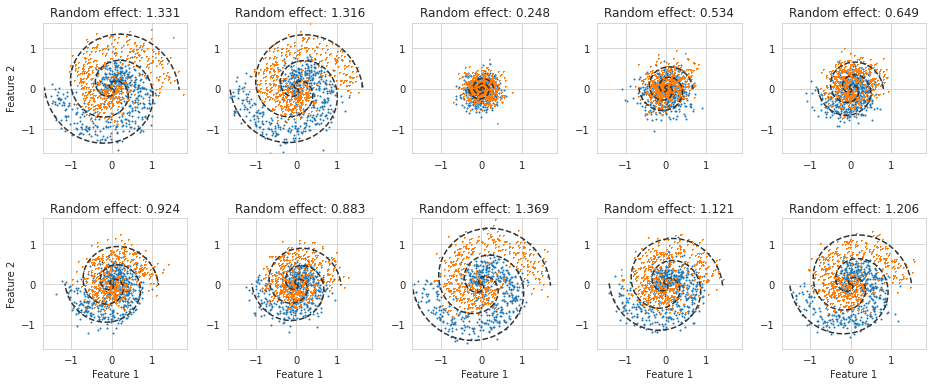

In [4]:
fig, ax = plot_clusters(arrX, arrZ, arrY, arrRadii, {'degrees': 360, 'classes': 2})
plt.show()

In [5]:
def base_model():
    tInput = tkl.Input(2)
    tDense1 = tkl.Dense(4, activation='relu')(tInput)
    tDense2 = tkl.Dense(4, activation='relu')(tDense1)
    tDense3 = tkl.Dense(4, activation='relu')(tDense2)
    tOutput = tkl.Dense(2, activation='softmax')(tDense3)
    
    model = tf.keras.Model(tInput, tOutput)
    model.compile(loss='categorical_crossentropy',
                  metrics=['accuracy'],
                  optimizer=tf.keras.optimizers.Adam())
    
    return model

def concat_model(batches):
    tInput = tkl.Input(2)
    tInputZ = tkl.Input(batches)
    
    tConcat = tkl.Concatenate(axis=-1)([tInput, tInputZ])
    
    tDense1 = tkl.Dense(4, activation='relu')(tConcat)
    tDense2 = tkl.Dense(4, activation='relu')(tDense1)
    tDense3 = tkl.Dense(4, activation='relu')(tDense2)
    tOutput = tkl.Dense(2, activation='softmax')(tDense3)
    
    model = tf.keras.Model((tInput, tInputZ), tOutput)
    model.compile(loss='categorical_crossentropy',
                  metrics=['accuracy'],
                  optimizer=tf.keras.optimizers.Adam())
    
    return model

def me_model(batches):
    tInput = tkl.Input(2)
    tInputZ = tkl.Input(batches)
    
    tDense1 = tkl.Dense(4, activation='relu')(tInput)
    tDense2 = tkl.Dense(4, activation='relu')(tDense1)
    tDense3 = tkl.Dense(4, activation='relu')(tDense2)
    
    tRE = RandomEffects(2, post_loc_init_scale=0, post_scale_init_min=0.1, 
                        post_scale_init_range=0.1, kl_weight=1/8000, 
                        prior_scale=0.5,
                        name='re_slope')(tInputZ)
    tConcat = tkl.Concatenate(axis=-1)([tDense3, tRE * tInput])
    tOutput = tkl.Dense(2, activation='softmax')(tConcat)
           
    model = tf.keras.Model((tInput, tInputZ), tOutput)
    model.compile(loss='categorical_crossentropy',
                  metrics=['accuracy'],
                  optimizer=tf.keras.optimizers.Adam())
    
    return model
    
def normality_reg(x):
    featurewise_mean = tf.reduce_mean(x, axis=0)
    mean_cubed_res = tf.reduce_mean(tf.pow(x - featurewise_mean, 3), axis=0)
    mean_squared_res = tf.reduce_mean(tf.pow(x - featurewise_mean, 2), axis=0)
    skewness = mean_cubed_res / (tf.pow(mean_squared_res, 1.5) + 1e-7)

    mean_quat_res = tf.reduce_mean(tf.pow(x - featurewise_mean, 4), axis=0)
    kurtosis = (mean_quat_res / (tf.pow(mean_squared_res, 2) + 1e-7)) - 3

    return 0.01*tf.reduce_sum(tf.abs(skewness)) + tf.reduce_sum(tf.abs(kurtosis))
    
def me_det_model(batches):
    tInput = tkl.Input(2)
    tInputZ = tkl.Input(batches)
    
    tDense1 = tkl.Dense(4, activation='relu')(tInput)
    tDense2 = tkl.Dense(4, activation='relu')(tDense1)
    tDense3 = tkl.Dense(4, activation='relu')(tDense2)
    
    tRE = tkl.Dense(2, activation='linear', 
                    # kernel_initializer=tf.keras.initializers.Constant(0.),
                    kernel_initializer=tf.keras.initializers.he_normal(),
                    kernel_regularizer=normality_reg, 
                    use_bias=False,
                    name='re_slope')(tInputZ)
    
    # tConcat = tkl.Concatenate(axis=-1)([tDense3, tRE * tInput])
    # tOutput = tkl.Dense(2, activation='softmax')(tConcat)
     
    tOutputFE = tkl.Dense(2, activation='linear')(tDense3)
    tOutputRE = tkl.Dot(axes=-1)([tRE, tInput])
    tOutput = tkl.Softmax()(tOutputFE + tOutputRE)
           
    model = tf.keras.Model((tInput, tInputZ), tOutput)
    model.compile(loss='categorical_crossentropy',
                  metrics=['accuracy'],
                  optimizer=tf.keras.optimizers.Adam())
    
    return model

In [6]:
def crossvalidate(model_fn, z_input=False):
    dfResults = pd.DataFrame(index=range(arrZ.shape[1]), columns=['Train', 'Test', 'Held-out group'])
    for iBatch in range(arrZ.shape[1]):
        arrXSeen = arrX[arrZ[:, iBatch] == 0, :]
        arrYSeen = arrY[arrZ[:, iBatch] == 0]
        arrZSeen = arrZ[arrZ[:, iBatch] == 0, :]
        arrZSeen = np.concatenate([arrZSeen[:, :iBatch], arrZSeen[:, (iBatch+1):]], axis=1)
        
        arrXUnseen = arrX[arrZ[:, iBatch] == 1, :]
        arrYUnseen = arrY[arrZ[:, iBatch] == 1]
        arrZUnseen = np.zeros((arrXUnseen.shape[0], arrZSeen.shape[1]))
        
        splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=32)
        # Stratify split by batch membership and class
        arrStrat = np.array([str(y) + str(np.where(z)[0]) for y, z in zip(arrYSeen, arrZSeen)])
        
        arrTrainIdx, arrTestIdx = next(splitter.split(arrXSeen, arrStrat))
        arrXSeenTrain = arrXSeen[arrTrainIdx]
        arrYSeenTrain = arrYSeen[arrTrainIdx]
        arrZSeenTrain = arrZSeen[arrTrainIdx]
        arrXSeenTest = arrXSeen[arrTestIdx]
        arrYSeenTest = arrYSeen[arrTestIdx]
        arrZSeenTest = arrZSeen[arrTestIdx]
        
        tf.random.set_seed(89)
        if z_input:
            model = model_fn(arrZSeen.shape[1])
            inputsTrain = (arrXSeenTrain, arrZSeenTrain)
            inputsTest = (arrXSeenTest, arrZSeenTest)
            inputsUnseen = (arrXUnseen, arrZUnseen)
        else:
            model = model_fn()
            inputsTrain = arrXSeenTrain
            inputsTest = arrXSeenTest
            inputsUnseen = arrXUnseen
            
        model.fit(inputsTrain, arrYSeenTrain, batch_size=32, epochs=100, verbose=0)
        dfResults['Train'].loc[iBatch] = model.evaluate(inputsTrain, arrYSeenTrain, verbose=0)[1]
        dfResults['Test'].loc[iBatch] = model.evaluate(inputsTest, arrYSeenTest, verbose=0)[1]       
        dfResults['Held-out group'].loc[iBatch] = model.evaluate(inputsUnseen, arrYUnseen, verbose=0)[1]       
                        
    return dfResults

In [7]:
dfPlain = crossvalidate(base_model)
print(dfPlain.mean())
print(dfPlain.std())

Train             0.715847
Test              0.717611
Held-out group    0.701000
dtype: float64
Train             0.014523
Test              0.019181
Held-out group    0.129309
dtype: float64


In [8]:
dfConcat = crossvalidate(concat_model, z_input=True)
print(dfConcat.mean())
print(dfConcat.std())

Train             0.717014
Test              0.714778
Held-out group    0.550500
dtype: float64
Train             0.015760
Test              0.014561
Held-out group    0.028140
dtype: float64


In [9]:
dfME = crossvalidate(me_model, z_input=True)
print(dfME.mean())
print(dfME.std())

Train             0.741806
Test              0.745389
Held-out group    0.706200
dtype: float64
Train             0.011903
Test              0.011529
Held-out group    0.130094
dtype: float64


In [10]:
# dfMEDet = crossvalidate(me_det_model, z_input=True)
# dfMEDet.mean()

In [11]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=32)
# Stratify split by batch membership and class
arrStrat = np.array([str(y) + str(np.where(z)[0]) for y, z in zip(arrY, arrZ)])

arrTrainIdx, arrTestIdx = next(splitter.split(arrX, arrStrat))
arrXTrain = arrX[arrTrainIdx]
arrYTrain = arrY[arrTrainIdx]
arrZTrain = arrZ[arrTrainIdx]
arrXTest = arrX[arrTestIdx]
arrYTest = arrY[arrTestIdx]
arrZTest = arrZ[arrTestIdx]

In [12]:
from scipy.ndimage.filters import gaussian_filter

def plot_decision_boundary(model, X, Y, Z=None, ax=None, vmax=2):       
    arrGridX1, arrGridX2 = np.mgrid[-vmax:vmax+0.1:0.1, -vmax:vmax+0.1:0.1]
    arrGridX = np.stack([arrGridX1.flatten(), arrGridX2.flatten()], axis=0).T
    if Z is not None:
        arrGridZ = np.zeros((arrGridX.shape[0], Z.shape[1]))
        arrGridZ[:, Z.sum(axis=0).argmax()] = 1
        arrGridYFlat = model.predict((arrGridX, arrGridZ), verbose=0)
    else:
        arrGridYFlat = model.predict(arrGridX, verbose=0) 

    arrGridY = (arrGridYFlat[:, 1] >= 0.5).reshape(arrGridX1.shape).astype(int)
    # arrGridY = gaussian_filter(arrGridY, 0.25)
    
    if ax is None:
        ax = plt.gca()
    ax.contour(arrGridX1, arrGridX2, arrGridY, levels=1, colors='k')  
    ax.contourf(arrGridX1, arrGridX2, arrGridY, levels=1, colors=['C0', 'C1'], alpha=0.5)    
    ax.scatter(X[Y[:, 0] == 1, 0], X[Y[:, 0] == 1, 1], c='C0', s=5, alpha=0.9)
    ax.scatter(X[Y[:, 1] == 1, 0], X[Y[:, 1] == 1, 1], c='C1', s=10, alpha=0.9, marker='P')
        
    return fig, ax

250/250 [==============================] - 0s 1ms/step - loss: 0.5190 - accuracy: 0.7129


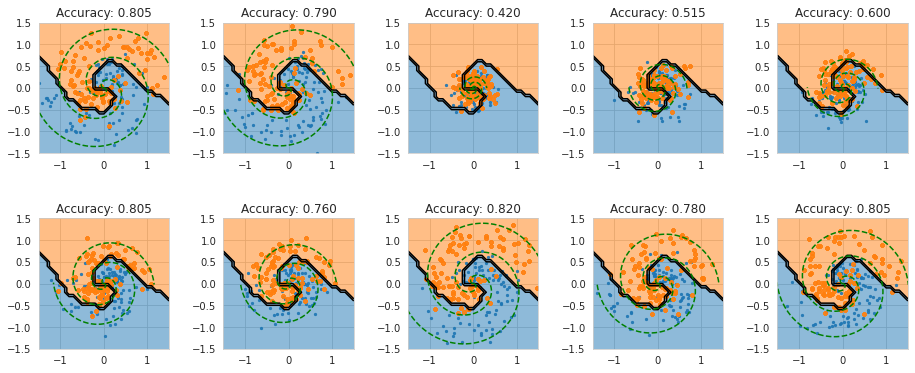

In [13]:
tf.random.set_seed(82)
modelBase = base_model()
modelBase.fit(arrXTrain, arrYTrain, batch_size=32, epochs=100, verbose=0)
modelBase.evaluate(arrXTrain, arrYTrain)

fig, ax = plt.subplots(2, 5, figsize=(16, 6), gridspec_kw={'hspace': 0.5})
vmax = 1.5
for iCluster in range(arrZTest.shape[1]):
    arrXCluster = arrXTest[arrZTest[:, iCluster]==1, :]
    arrYCluster = arrYTest[arrZTest[:, iCluster]==1, :]
    plot_decision_boundary(modelBase, arrXCluster, arrYCluster,
                            ax=ax.flatten()[iCluster],
                            vmax=vmax)
    
    arrTrueBoundary = make_spiral_true_boundary(classes=2, degrees=360, radius=arrRadii[iCluster])
    ax.flatten()[iCluster].plot(arrTrueBoundary[:1000, 0], arrTrueBoundary[:1000, 1], c='g', ls='--')   
    ax.flatten()[iCluster].plot(arrTrueBoundary[1000:, 0], arrTrueBoundary[1000:, 1], c='g', ls='--')
    
    ax.flatten()[iCluster].set_xlim(-vmax, vmax)
    ax.flatten()[iCluster].set_ylim(-vmax, vmax)
    ax.flatten()[iCluster].set_aspect('equal')
    
    acc = modelBase.evaluate(arrXCluster, arrYCluster, verbose=0)[1]
    ax.flatten()[iCluster].set_title(f'Accuracy: {acc:.03f}')
    
fig.show()
# fig.savefig('/home2/s169685/Downloads/base.png', dpi=600)
fig.savefig('/home2/s169685/Downloads/base.svg', dpi=600)

del modelBase

63/63 [==============================] - 0s 2ms/step - loss: 0.5022 - accuracy: 0.7370


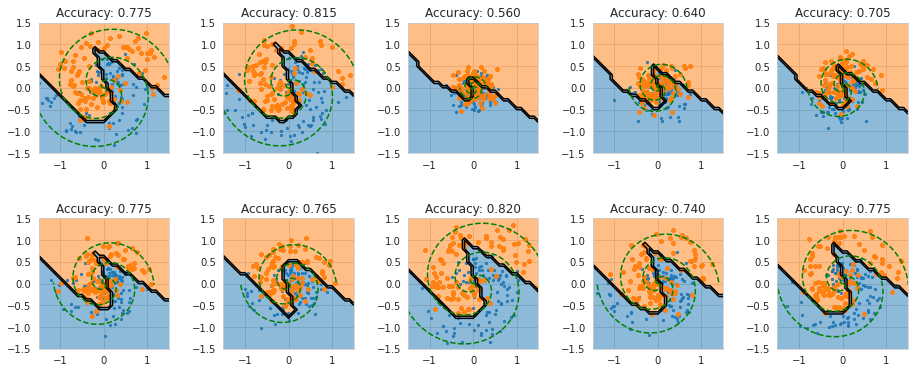

In [14]:
tf.random.set_seed(82)
modelConcat = concat_model(10)
modelConcat.fit((arrXTrain, arrZTrain), arrYTrain, batch_size=32, epochs=100, verbose=0)
modelConcat.evaluate((arrXTest, arrZTest), arrYTest)

fig, ax = plt.subplots(2, 5, figsize=(16, 6), gridspec_kw={'hspace': 0.5})
vmax = 1.5
for iCluster in range(arrZTest.shape[1]):
    arrXCluster = arrXTest[arrZTest[:, iCluster]==1, :]
    arrYCluster = arrYTest[arrZTest[:, iCluster]==1, :]
    arrZCluster = arrZTest[arrZTest[:, iCluster]==1, :]
    plot_decision_boundary(modelConcat, arrXCluster, arrYCluster, arrZCluster,
                            ax=ax.flatten()[iCluster],
                            vmax=vmax)
    
    arrTrueBoundary = make_spiral_true_boundary(classes=2, degrees=360, radius=arrRadii[iCluster])
    ax.flatten()[iCluster].plot(arrTrueBoundary[:1000, 0], arrTrueBoundary[:1000, 1], c='g', ls='--')   
    ax.flatten()[iCluster].plot(arrTrueBoundary[1000:, 0], arrTrueBoundary[1000:, 1], c='g', ls='--')
    
    ax.flatten()[iCluster].set_xlim(-vmax, vmax)
    ax.flatten()[iCluster].set_ylim(-vmax, vmax)
    ax.flatten()[iCluster].set_aspect('equal')
    
    acc = modelConcat.evaluate((arrXCluster, arrZCluster), arrYCluster, verbose=0)[1]
    ax.flatten()[iCluster].set_title(f'Accuracy: {acc:.03f}')

fig.show()
fig.savefig('/home2/s169685/Downloads/concat.svg', dpi=600)

del modelConcat

63/63 [==============================] - 0s 2ms/step - loss: 0.4548 - accuracy: 0.7430


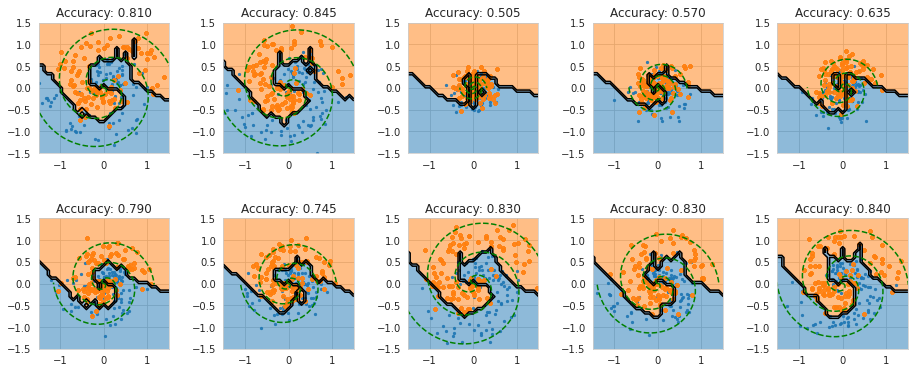

In [15]:
tf.random.set_seed(82)
modelME = me_model(10)
modelME.fit((arrXTrain, arrZTrain), arrYTrain, batch_size=32, epochs=100, verbose=0)
modelME.evaluate((arrXTest, arrZTest), arrYTest)

fig, ax = plt.subplots(2, 5, figsize=(16, 6), gridspec_kw={'hspace': 0.5})
vmax = 1.5
for iCluster in range(arrZTest.shape[1]):
    arrXCluster = arrXTest[arrZTest[:, iCluster]==1, :]
    arrYCluster = arrYTest[arrZTest[:, iCluster]==1, :]
    arrZCluster = arrZTest[arrZTest[:, iCluster]==1, :]
    plot_decision_boundary(modelME, arrXCluster, arrYCluster, arrZCluster,
                            ax=ax.flatten()[iCluster],
                            vmax=vmax)
    
    arrTrueBoundary = make_spiral_true_boundary(classes=2, degrees=360, radius=arrRadii[iCluster])
    ax.flatten()[iCluster].plot(arrTrueBoundary[:1000, 0], arrTrueBoundary[:1000, 1], c='g', ls='--')   
    ax.flatten()[iCluster].plot(arrTrueBoundary[1000:, 0], arrTrueBoundary[1000:, 1], c='g', ls='--')
    
    ax.flatten()[iCluster].set_xlim(-vmax, vmax)
    ax.flatten()[iCluster].set_ylim(-vmax, vmax)
    ax.flatten()[iCluster].set_aspect('equal')
    
    acc = modelME.evaluate((arrXCluster, arrZCluster), arrYCluster, verbose=0)[1]
    ax.flatten()[iCluster].set_title(f'Accuracy: {acc:.03f}')
    
fig.show()
fig.savefig('/home2/s169685/Downloads/me.svg', dpi=600)

del modelME

In [16]:
# tf.random.set_seed(82)
# modelME = me_det_model(10)
# modelME.fit((arrXTrain, arrZTrain), arrYTrain, batch_size=32, epochs=100, verbose=0)
# modelME.evaluate((arrXTest, arrZTest), arrYTest)

# fig, ax = plt.subplots(2, 5, figsize=(16, 6), gridspec_kw={'hspace': 0.5})
# for iCluster in range(arrZTest.shape[1]):
#     plot_decision_boundary(modelME, 
#                             arrXTest[arrZTest[:, iCluster]==1, :], 
#                             arrYTest[arrZTest[:, iCluster]==1, :], 
#                             arrZTest[arrZTest[:, iCluster]==1, :],
#                             ax=ax.flatten()[iCluster],
#                             vmax=2.5)
#     ax.flatten()[iCluster].set_xlim(-2.5, 2.5)
#     ax.flatten()[iCluster].set_ylim(-2.5, 2.5)
#     ax.flatten()[iCluster].set_aspect('equal')
    
# fig.show()

# del modelME

<AxesSubplot:xlabel='Model', ylabel='Accuracy'>

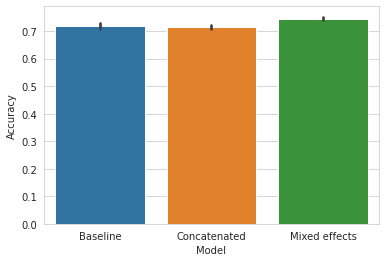

In [17]:
dfPlainLong = pd.melt(dfPlain, var_name='Partition', value_name='Accuracy')
dfPlainLong['Model'] = 'Baseline'
dfConcatLong = pd.melt(dfConcat, var_name='Partition', value_name='Accuracy')
dfConcatLong['Model'] = 'Concatenated'
dfMELong = pd.melt(dfME, var_name='Partition', value_name='Accuracy')
dfMELong['Model'] = 'Mixed effects'

dfAll = pd.concat([dfPlainLong, dfConcatLong, dfMELong], axis=0)

sns.barplot(data=dfAll.loc[dfAll['Partition'] == 'Test'], x='Model', y='Accuracy')

<AxesSubplot:xlabel='Model', ylabel='Accuracy'>

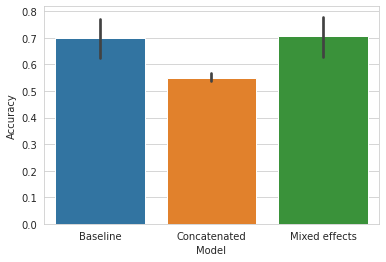

In [18]:
sns.barplot(data=dfAll.loc[dfAll['Partition'] == 'Held-out group'], x='Model', y='Accuracy')

In [20]:
scipy.stats.ttest_rel(dfPlain['Test'], dfME['Test'])

Ttest_relResult(statistic=-7.568417793149892, pvalue=3.437793151248194e-05)

In [19]:
import scipy.stats
scipy.stats.ttest_rel(dfPlain['Held-out group'], dfME['Held-out group'])

Ttest_relResult(statistic=-2.2716277701025893, pvalue=0.04923187473677197)